# Regional and Local Sea Level Change   

## Setup

First, we need to import all the necessary libraries. 

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import json
import pandas as pd
import os
from urllib.request import urlretrieve #used for downloading files
from scipy.stats import linregress
import requests
import seaborn as sns
from scipy.signal import detrend
import cartopy.crs as ccrs
import cartopy.feature as cfeature



## Retrieve Data Sources

We are interested in getting tide gauge and alitmetry data for Palau (and its EEZ) for 1993 through 2018.
Let's first establish where the tide gauge is by looking at the tide gauge dataset.

### Retrieve the location of the Malakal, Palau tide gauge

In [2]:
url = 'https://uhslc.soest.hawaii.edu/data/meta.geojson' #<<--- THIS IS A "HIDDEN" URL? I CAN'T FIND IT BY CLICKING AROUND THE WEBSITE. 

#parse this url to get lat/lon of Malakal tide gauge
r = requests.get(url)
data = r.json()
for i in range(len(data['features'])):
    if data['features'][i]['properties']['name'] == 'Malakal':
        lat = data['features'][i]['geometry']['coordinates'][1]
        lon = data['features'][i]['geometry']['coordinates'][0]
        break

lat,lon    

(7.33, 134.463)

Next, let's establish a period of record. (Start and end time for analysis.) Here we'll go from 1993-2018 for now, so I can compare SL_magnitude_results with https://ccar.colorado.edu/altimetry/ as a sanity check.

In [3]:
# establish the time period of interest
start_date = dt.datetime(1993,1,1)
end_date = dt.datetime(2018,12,31)

# also have them as strings, for plotting
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

### Retrieve the EEZ boundary for Palau

Next we'll define the area we want to look at using the EEZ boundary. This can be obtained from XXX. For now it's in the data directory.

In [4]:
# Retrieve the EEZ for Palau
with open('../data/palauEEZ.json') as f:
    palau = json.load(f)

# extract the coordinates of the EEZ
palau_eez = np.array(palau['features'][0]['geometry']['coordinates'][0][0])

# get the min and max lat and lon of the EEZ, helpful for obtaining CMEMS data
min_lon = np.min(palau_eez[:,0])
max_lon = np.max(palau_eez[:,0])
min_lat = np.min(palau_eez[:,1])
max_lat = np.max(palau_eez[:,1])

### Retrieve altimetry data 

In [5]:
# To get this file, run get_CMEMS_data.py from the playground directory in a terminal with python >= 3.9 + copernicus_marine_client installed
ds = xr.open_dataset('../data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_adt-sla_129.62E-136.88E_1.62N-11.88N_1993-01-01-2023-04-30.nc')
# slice the data to time 1993-01-01 to 2018-12-31
ds = ds.sel(time=slice(start_date, end_date))
ds

# Note I am downloading a product direct from CMEMS, not using the CMEMS data from Ayesha - I am unclear of the source.

<xarray.Dataset>
Dimensions:    (time: 9496, latitude: 42, longitude: 30)
Coordinates:
  * latitude   (latitude) float32 1.625 1.875 2.125 2.375 ... 11.38 11.62 11.88
  * longitude  (longitude) float32 129.6 129.9 130.1 130.4 ... 136.4 136.6 136.9
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
Data variables:
    adt        (time, latitude, longitude) float64 ...
    sla        (time, latitude, longitude) float64 ...
Attributes: (12/45)
    Conventions:                       CF-1.6
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    cdm_data_type:                     Grid
    comment:                           Sea Surface Height measured by Altimet...
    contact:                           servicedesk.cmems@mercator-ocean.eu
    creator_email:                     servicedesk.cmems@mercator-ocean.eu
    ...                                ...
    time_coverage_duration:            P1D
    time_coverage_end:                 1993-01-01T12:00:00Z
    time_coverage_resolution:          P1D
    time_coverage_start:               1992-12-31T12:00:00Z
    title:                             DT merged all satellites Global Ocean ...
    copernicus_marine_client_version:  0.10.0

In [6]:
# Here we are going to use the research quality data set, which is the best available data set for tide gauge data
uhslc_id = 7
fname = f'h{uhslc_id:03}b.nc' # h for hourly, d for daily, added b for research quality data for deployment B
datadir = './'
url = "https://uhslc.soest.hawaii.edu/data/netcdf/rqds/pacific/hourly/" # Research Quality Data Set only goes thru 2018

path = os.path.join(datadir, fname)

if not os.path.exists(path):
    urlretrieve(os.path.join(url, fname), path) 
    
rsl = xr.open_dataset(fname)
station_name = rsl['station_name'].values[0]
rsl

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 434985)
Coordinates:
  * time                  (time) datetime64[ns] 1969-05-18T15:00:00 ... 2018-...
  * record_id             (record_id) int16 72
Data variables: (12/13)
    sea_level             (record_id, time) float32 ...
    lat                   (record_id) float32 ...
    lon                   (record_id) float32 ...
    station_name          (record_id) |S7 b'Malakal'
    station_country       (record_id) |S5 ...
    station_country_code  (record_id) float32 ...
    ...                    ...
    version               (record_id) |S1 ...
    gloss_id              (record_id) float32 ...
    ssc_id                (record_id) |S4 ...
    decimation_method     (record_id) int16 ...
    reference_code        (record_id) |S1 ...
    reference_offset      (record_id) int16 ...
Attributes:
    title:                  JASL/UHSLC Research Quality Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2023-04-04T01:53:36Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The Joint Archive for Sea Level (JASL) Research Q...
    processing_level:       The JASL receives hourly data from regional and n...
    acknowledgment:         The JASL/UHSLC Research Quality Data Set is suppo...

## Process the data

 Convert tide gauge data into daily record for the POR in units of meters to match the CMEMS data. Normalize the data to the 1993-2012 epoch.

In [7]:
# Extract the data for the 1993-2019 period
tide_gauge_data_POR = rsl['sea_level'].sel(time=slice(start_date, end_date))

# Convert to meters and drop any NaN values
tide_gauge_data_meters = tide_gauge_data_POR / 1000  # Convert from mm to meters
tide_gauge_data_clean = tide_gauge_data_meters.dropna(dim='time')

# Resampling the tide gauge data to daily mean before subtracting the epoch mean, to match the CMEMS data
tide_gauge_daily_avg = tide_gauge_data_clean.resample(time='1D').mean()

# Normalize the data relative to the 1993-2012 epoch (we will level it with CMEMS 93-12 epoch later)
epoch_start, epoch_end = start_date, '2011-12-31'
epoch_daily_avg = tide_gauge_daily_avg.sel(time=slice(epoch_start, epoch_end))
epoch_daily_mean = epoch_daily_avg.mean()

rsl_daily = tide_gauge_daily_avg - epoch_daily_mean

rsl_daily.attrs['units'] = 'm'

rsl_daily


<xarray.DataArray 'sea_level' (record_id: 1, time: 9496)>
array([[-0.12749314, -0.1223681 , -0.16636801, ..., -0.2099514 ,
        -0.18257642, -0.61703473]], dtype=float32)
Coordinates:
  * record_id  (record_id) int16 72
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
Attributes:
    units:    m

Run a quick check to see if the Ab SL from CMEMS is in fact zeroed about the 1993-2012 epoch. Curse the details.

In [8]:
# Normalize tide gauge data to CMEMS 1993-2012 epoch
epoch_daily_mean_cmems = ds['sla'].sel(time=slice(epoch_start, epoch_end)).sel(longitude=lon, latitude=lat, method='nearest').mean(dim='time')

formatted_mean = format(epoch_daily_mean_cmems.values, ".2f")
print(f' The mean for the [1993,2012] epoch of the SLA is {formatted_mean} m. Re-check source data to make sure this is correct.')


 The mean for the [1993,2012] epoch of the SLA is 0.02 m. Re-check source data to make sure this is correct.


### Clip
Clip the Data Set to the area/grid of Interest

We will focus only on the grid cells nearest to the Malakal tide gauge.

In [9]:
sla = ds['sla'].sel(time=slice(start_date, end_date))
time_cmems = pd.to_datetime(sla['time'].values)

# Extract data for the nearest point to the tide gauge location
sla_nearest = sla.sel(longitude=lon, latitude=lat, method='nearest')

sla_nearest_lat = sla_nearest['latitude'].values
sla_nearest_lon = sla_nearest['longitude'].values

# Format lat lon strings to have decimal symbol and N/S and E/W
lat_str = f'{np.abs(sla_nearest_lat):.3f}\u00B0{"N" if sla_nearest_lat > 0 else "S"}'
lon_str = f'{np.abs(sla_nearest_lon):.3f}\u00B0{"E" if sla_nearest_lon > 0 else "W"}'

print(f'The closest altimetry grid point is {lat_str}, {lon_str}')


The closest altimetry grid point is 7.375°N, 134.375°E


Two functions here to calculate the trend (and error). One is yearly means, the other uses daily means. No other filtering is done, just plain vanilla regression. Matthew's code is more simple: takes the POR, and subtracts the detrended data (which is made with "detrend_NaN" which I'm assuming is a custom function in home/kaimoku/mwidlans. )

In [10]:
# Define a function to calculate the trend from yearly anomaly data
def process_data_yearly(time, sea_level_anomaly):
    # Convert to DataFrame for easier handling
    df = pd.DataFrame({
        'Time': time,
        'Sea_Level_Anomaly': sea_level_anomaly.flatten()  # Flattening to ensure 1D array
    })

    # cut off the data at the end of the POR
    df = df[df['Time'] < '2019-01-01']

    # Resampling to get the mean for each year
    annual_mean = df.resample('Y', on='Time').mean()

    # Preparing data for linear regression
    years = annual_mean.index.year
    mean = annual_mean['Sea_Level_Anomaly'].values

    years_datetime = pd.to_datetime(years, format='%Y')

    # Perform linear regression
    slope, intercept, _, _, std_err = linregress(years, mean)

    # Calculate the trend line for years
    trend_line = intercept + slope * years

    return years_datetime, mean, trend_line, slope, std_err

In [11]:
# Define a function to calculate the trend from yearly anomaly data
def process_data_daily(time, sea_level_anomaly):
    # Convert to DataFrame for easier handling
    df = pd.DataFrame({
        'Time': time,
        'Sea_Level_Anomaly': sea_level_anomaly.flatten()  # Flattening to ensure 1D array
    })

    # cut off the data at the end of the POR, hard-coded for now
    df = df[df['Time'] < '2019-01-01']

    # remove nan values
    df = df.dropna()

    # Preparing data for linear regression
    days = (df['Time'] - df['Time'][0]).dt.days
    mean = df['Sea_Level_Anomaly'].values

    days_datetime = pd.to_datetime(days, unit='D', origin=df['Time'][0])

    # Perform linear regression
    slope, intercept, _, _, std_err = linregress(days, mean)

    # Calculate the trend line for days
    trend_line = intercept + slope * days

    slope = slope * 365.25 # convert slope from m/day to m/year
    std_err = std_err * 365.25 # convert std_err from m/day to m/year

    return days_datetime, mean, trend_line, slope, std_err


In [12]:
# Define a new function to calculate the trend. This time, detrend the data first, then calculate the trend as the data-detrended data

def process_data_detrended(time, sea_level_anomaly):

    df = pd.DataFrame({
        'Time': time_cmems,
        'Sea_Level_Anomaly': sea_level_anomaly.flatten()  # Flattening to ensure 1D array
    })

    # cut off the data at the end of the POR, hard-coded for now
    df = df[df['Time'] < '2019-01-01']

     # remove nan values
    df = df.dropna()

    # Preparing data for linear regression
    days = (df['Time'] - df['Time'][0]).dt.days
    sea_level_anomaly = df['Sea_Level_Anomaly'].values
    days_datetime = pd.to_datetime(days, unit='D', origin=df['Time'][0])

    # detrend the data
    sea_level_anomaly_detrended = detrend(sea_level_anomaly) # I don't have much control over this...what's the error??

    sea_level_trend = sea_level_anomaly - sea_level_anomaly_detrended
    trend_mag = sea_level_trend[-1] - sea_level_trend[0] 

    # get the rate by dividing by the number of years in the time period
    trend_rate = trend_mag / (len(sea_level_trend) / 365.25) # m/year

    return days_datetime, sea_level_trend, trend_rate, trend_mag

In [13]:
# Calculate the trend line for the CMEMS and tide gauge data
days_sla_datetime, trend_line_sla, trend_sla, trend_mag_sla = process_data_detrended(time_cmems, sla_nearest.values)
days_rsl_datetime, trend_line_rsl, trend_rsl, trend_mag_rsl = process_data_detrended(rsl_daily['time'].values, rsl_daily.values)

Plot the timeseries

In [14]:

# # Set the style of the plot
# sns.set_style("whitegrid")

# # Create a color palette
# palette = sns.color_palette("Paired")

# # Create the figure and the axes
# fig, ax = plt.subplots(figsize=(15, 5))

# # Plot the data

# # plot altimetry data
# ax.scatter(sla_df['Time'], 100*sla_df['Sea_Level_Anomaly'], label='Altimetry', color=palette[0], alpha=0.5, s= 5)
# ax.plot(years_sla_datetime, 100*trend_line_sla, label='Altimetry Trend', color=palette[1], linestyle='--')

# # set 'zero' to be the CMEMS epoch mean
# rsl_daily_zeroed = rsl_daily + epoch_daily_mean_cmems.values;
# trend_line_rsl_zeroed = trend_line_rsl + epoch_daily_mean_cmems.values;

# # plot tide gauge data
# ax.scatter(rsl_daily['time'], 100*rsl_daily_zeroed, label='Tide Gauge', color=palette[2], alpha=0.5, s= 10)
# ax.plot(years_rsl_datetime, 100*trend_line_rsl_zeroed, label='Tide Gauge Trend', color=palette[3], linestyle='--')

# # Set the title and labels
# ax.set_title(f'Altimetry ({lat_str}, {lon_str}) vs Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})', fontsize=16)
# ax.set_xlabel('Year', fontsize=14)
# ax.set_ylabel('Height (cm)', fontsize=14)

# # Set the y limits
# ax.set_ylim([-35, 35])

# # Set the x limits
# ax.set_xlim([start_date, end_date])

# # Add a legend
# ax.legend()

In [15]:
# Print the results
print('The results')
print('The trend in RSL sea level anomaly is {:.3f} cm/year, with Δ= {:.2f} cm'.format(100*trend_rsl, 100*trend_mag_rsl))
print('The trend in ASL sea level anomaly is {:.3f} cm/year, with Δ= {:.2f} cm'.format(100*trend_sla, 100*trend_mag_sla))


The results
The trend in RSL sea level anomaly is 0.488 cm/year, with Δ= 12.55 cm
The trend in ASL sea level anomaly is 0.559 cm/year, with Δ= 14.54 cm


### Set the Datum to MHHW

Not sure that MHHW datum is helpful for this??? Unless it is to look at "where is the water today relative to a known datum?" Note that I am using daily averages here, so it seems low. (And that's because it is. MHHW doesn't stay there all day...)

In [16]:
# The sea level anomaly is referenced to the [1993, 2012] period; Let's reset this to MHHW of Malakal tide gauge
# get the MHHW from the UH Sea Level Center website
mhhw = 2.162  # in meters

# Resetting the sea level anomaly to MHHW of Malakal tide gauge
rsl_daily_mhhw = rsl_daily + epoch_daily_mean - mhhw #add the epoch mean back to the tide gauge data, then subtract MHHW
trend_line_rsl_mhhw = trend_line_rsl + epoch_daily_mean.values - mhhw #add the epoch mean back to the trend line, then subtract MHHW

# now do a similar thing for the altimetry data
sla_mhhw = sla_nearest + epoch_daily_mean-epoch_daily_mean_cmems - mhhw #yikes, this is foul looking
trend_line_sla_mhhw = trend_line_sla + epoch_daily_mean.values-epoch_daily_mean_cmems.values- mhhw #add the epoch mean back to the trend line, then subtract MHHW

### Calculate change
Calculate the Absolute Sea Level Change (magnitude in cm) within the area/grid of Interest for the Period of Record (1993-2022).

When we downloaded the data, we specified that it be from 1993 to 2022, but let's double check:

In [17]:
# # define a function to detrend the data for each lat,lon grid point
# def detrend(data, axis=0):
#     return data - np.mean(data, axis=axis)

# # detrend the data for each lat,lon grid point along the time axis
# sla_detrend = xr.apply_ufunc(detrend, sla, kwargs={'axis': 0})

# calculate the area weights as cosine of latitude (For a rectangular grid, this is equivalent to multiplying by the grid cell area)
weights = np.cos(np.deg2rad(sla.latitude))
weights.name = "weights"


In [18]:
# Function to calculate the trend line for each lat,lon grid point
def process_data(sea_level_anomaly, times):
    # Convert time to a numeric format (e.g., years since the start)
    years = pd.to_datetime(times).year

    # Perform linear regression
    slope, intercept, _, _, _ = linregress(years, sea_level_anomaly)
    slope = slope*100 #convert to cm/yr
    return slope

# Calculate the trend line with process_data function for every lat,lon grid point
trend_cmems = xr.apply_ufunc(
    process_data, 
    sla, 
    sla['time'], 
    input_core_dims=[['time'], ['time']],  # Specifying the core dimensions
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float, float]
)


In [19]:
# apply weights to the trend data
# trend_weighted = trend.weighted(weights)


# Do we want to bother with this???

### Plot a map
Plot the Results (in a map that includes the EEZ) – MAP

### Plot time series
Now we'll plot a time series that includes a trend line, the Absolute Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s – PLOT

(ASLtimeseries)=
### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

## Retrieve the Tide Station Data 

### Assess Station Data Quality 
for the POR (1993-2022 …consult w/Ayesha and John)

### Set the Datum to MHHW 
…and plot the hourly time series – PLOT

### Plot time series
Plot time series of monthly mean, that includes a trend line, the Relative Sea Level Sea Level Change (magnitude in cm) within area/s in proximity to the Tide Station/s – PLOT

(RSLtimeseries)=
### Calculate rate and magnitude of change
Calculate values for both the Trend (rate of change) and Magnitude of Change

## Combining both sources

### Create a Map 
that includes 1.4 (absolute change) with the addition of an icon/s depicting magnitude of (relative) change at the tide station/s (see UHLSC webpage) – MAP 

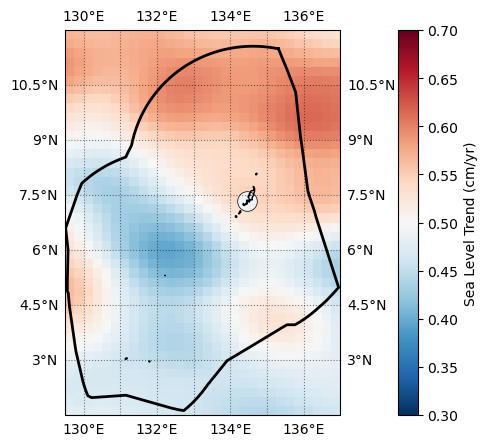

In [20]:
# plot a map of the trend
fig, ax = plt.subplots(figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# plot the trend
trend_cmems.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0.3, vmax=0.7, cmap='RdBu_r', cbar_kwargs={'label': 'Sea Level Trend (cm/yr)'})

ax.coastlines()
ax.add_feature(cfeature.LAND, color='lightgrey')
# add the EEZ
ax.plot(palau_eez[:, 0], palau_eez[:, 1], transform=ccrs.PlateCarree(), color='black', linewidth=2)
# show latitude and longitude grid lines
gl = ax.gridlines(draw_labels=True, linestyle=':', color='black', alpha=0.5)
# add the tide gauge location with black outlined dot, colored by the sea level value
ax.scatter(rsl['lon'], rsl['lat'], transform=ccrs.PlateCarree(), s=200, c=100*trend_rsl, cmap='RdBu_r', vmin=0.3, vmax=0.7,linewidth=0.5, edgecolor='black')


 ### Create a Time series plot 
 that include both Absolute (1.5) and Relative Time Series (2.3) – PLOT

Data points are daily means. Trend is calculated from daily means.


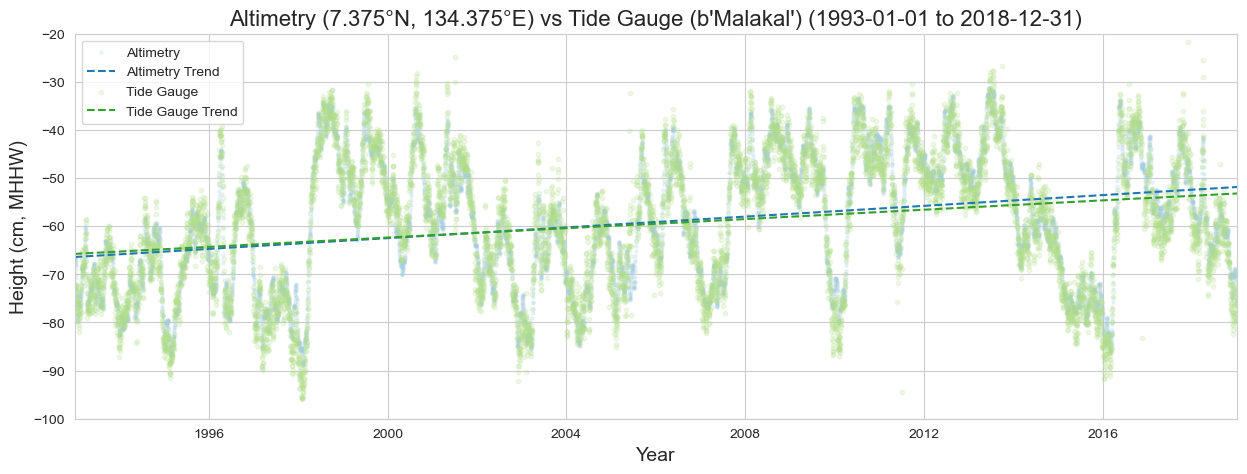

In [21]:

# Set the style of the plot
sns.set_style("whitegrid")

# Create a color palette
palette = sns.color_palette("Paired")

# Plot the timeseries
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(15, 5))
# plot altimetry data
ax.scatter(sla_mhhw['time'], 100*sla_mhhw, label='Altimetry', color=palette[0], alpha=0.2, s= 5)
ax.plot(days_sla_datetime, 100*trend_line_sla_mhhw, label='Altimetry Trend', color=palette[1], linestyle='--')

# plot tide gauge data
ax.scatter(rsl_daily_mhhw['time'], 100*rsl_daily_mhhw, label='Tide Gauge', color=palette[2], alpha=0.2, s= 10)
ax.plot(days_rsl_datetime, 100*trend_line_rsl_mhhw, label='Tide Gauge Trend', color=palette[3], linestyle='--')

# Set the title and labels
ax.set_title(f'Altimetry ({lat_str}, {lon_str}) vs Tide Gauge ({station_name}) ({start_date_str} to {end_date_str})', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Height (cm, MHHW)', fontsize=14)

# Set the y limits
ax.set_ylim([-100, -20])

# Set the x limits
ax.set_xlim([start_date, end_date])

# Add a legend
ax.legend()



print('Data points are daily means. Trend is calculated from daily means.') 

### Create a Table 
That compares the results of sections {numref}`ASLtimeseries` and {numref}`RSLtimeseries`– TABLE

In [22]:
# Create a dataframe with the results with trend, standard error, and magnitude of sea level change for altimetry and tide gauge data
SL_magnitude_results = pd.DataFrame({
    'Trend (cm/yr)': [100*trend_sla, 100*trend_rsl],
    'Δ Sea Level (cm)': [100*trend_mag_sla, 100*trend_mag_rsl]
}, index=['Altimetry', 'Tide Gauge'])



SL_magnitude_results['Latitude'] = [sla_nearest_lat, rsl['lat'].values[0]]  
SL_magnitude_results['Longitude'] = [sla_nearest_lon, rsl['lon'].values[0]]

# add also the data source for both altimetry and tide gauge data, and the location
SL_magnitude_results['Data Source'] = ['CMEMS SSH L4 0.25 deg (SLA)', 'UHSLC RQDS']

# add column for the time period
SL_magnitude_results['Time Period'] = [f'{start_date_str} to {end_date_str}', f'{start_date_str} to {end_date_str}']

# save to table
SL_magnitude_results.to_csv('../data/SL_magnitude_results.csv')


SL_magnitude_results

,Trend (cm/yr),Δ Sea Level (cm),Latitude,Longitude,Data Source,Time Period
Altimetry,0.559384,14.543223,7.375,134.375,CMEMS SSH L4 0.25 deg (SLA),1993-01-01 to 2018-12-31
Tide Gauge,0.487604,12.554221,7.33,134.462997,UHSLC RQDS,1993-01-01 to 2018-12-31
